In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torchvision.datasets import CIFAR10  
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

In [3]:
dataset_train = CIFAR10('/home/jupyter/mnt/datasets/cifar10',download=True, train=True)
dataset_test = CIFAR10('/home/jupyter/mnt/datasets/cifar10',download=True, train=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 85432384.06it/s]


Extracting /home/jupyter/mnt/datasets/cifar10/cifar-10-python.tar.gz to /home/jupyter/mnt/datasets/cifar10
Files already downloaded and verified


In [4]:
def show_images(dataset, num_images = 10):
    # Создаем подграфик 1x10
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))

    for i in range(num_images):
        # Получаем изображение и метку
        image, label = dataset[i]
        # Переводим изображение в формат (H, W, C) для отображения в Matplotlib
        image = np.array(image)
        # Отображаем изображение
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")

    plt.show()


________Train________


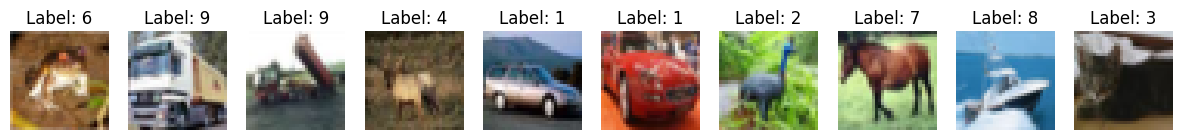

________Test________


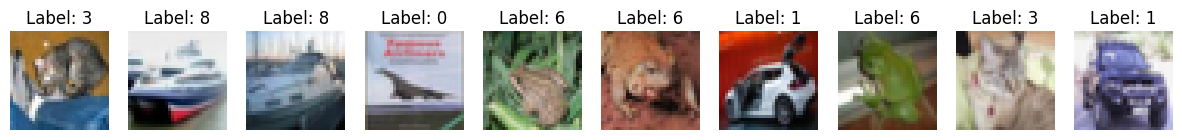

Размеры обучаеющей выборки: (50000, 32, 32, 3),
Размер тестововй выборки: (10000, 32, 32, 3)


In [5]:
print("________Train________")
show_images(dataset_train)
print("________Test________")
show_images(dataset_test)

print(f"Размеры обучаеющей выборки: {dataset_train.data.shape},") 
print(f"Размер тестововй выборки: {dataset_test.data.shape}")

In [6]:
def get_normalize(features: torch.Tensor):
    means = (features.data/255).mean(axis=(0, 1, 2))
    stds = (features.data/255).std(axis=(0, 1, 2))
    
    return means, stds

In [7]:
get_normalize(dataset_train)

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [11]:
len(dataset_train.data)

50000

In [ ]:

def get_augmentations(train: bool = True) -> T.Compose:
    
    means = [0.49139968, 0.48215841, 0.44653091]
    stds = [0.24703223, 0.24348513, 0.26158784]
    
    if train:
        
        train_transforms = T.Compose(
            [
                T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
                T.RandomHorizontalFlip(p=0.5),
                T.ToTensor(),
                T.Normalize(mean=means, std=stds)
            ]
        )
        return train_transforms
    else: 
        
        test_transforms = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=means, std=stds)
            ]
        )
        return test_transforms



In [ ]:
trans = get_augmentations()
train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=trans)
test_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=trans)


In [36]:
train_dataset.data.shape,test_dataset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Определение остаточного блока без downsample
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        # Первый сверточный слой
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        # Второй сверточный слой
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        identity = x  # Сохраняем входной тензор для skip connection
        
        # Прямой проход через два сверточных слоя с активацией ReLU
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Суммируем с входом (skip connection) и применяем ReLU
        out += identity
        out = F.relu(out)
        
        return out

# Определение упрощенного варианта ResNet-18
class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet18, self).__init__()
        # Начальный сверточный слой (без изменения размерности)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Группы слоев (все с одинаковым числом каналов)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(64, 2)
        self.layer3 = self._make_layer(64, 2)
        self.layer4 = self._make_layer(64, 2)
        
        # Глобальный усредненный пуллинг и выходной полносвязный слой
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
    
    def _make_layer(self, channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(ResidualBlock(channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Прямой проход через начальный сверточный слой
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Прямой проход через четыре группы слоев
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Глобальный пуллинг и полносвязный слой
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x




In [39]:
# Инициализация модели, функции потерь и оптимизатора
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet18(num_classes=10)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(device)

cuda


In [40]:
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) 
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [41]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) 
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [42]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        scheduler.step(valid_loss)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)
        
        print(f"Эпоха {epoch+1}")
        print(f"___Train___ Loss = {train_loss}, Accuracy = {train_accuracy}")
        print(f"___Test___  Loss = {valid_loss}, Accuracy = {valid_accuracy}")
        
    fig = plt.figure()
    fig.set_size_inches(16, 10)
    
    ax_1 = fig.add_subplot(1,2,1)
    plt.plot(range(num_epochs), train_accuracy_history, label="train")
    plt.plot(range(num_epochs), valid_accuracy_history, label="test")
    plt.scatter(range(num_epochs), train_accuracy_history)
    plt.scatter(range(num_epochs), valid_accuracy_history)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy_history")
    plt.legend()
    
    ax_2 = fig.add_subplot(1,2,2)
    plt.plot(range(num_epochs), train_loss_history, label="train")
    plt.plot(range(num_epochs), valid_loss_history, label="test")
    plt.scatter(range(num_epochs), train_loss_history)
    plt.scatter(range(num_epochs), valid_loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss_history")
    plt.legend()
    
            

Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s]


Эпоха 1
___Train___ Loss = 1.6684475900876858, Accuracy = 0.37546
___Test___  Loss = 1.5580765988416732, Accuracy = 0.4174


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.43it/s]


Эпоха 2
___Train___ Loss = 1.2858142640889454, Accuracy = 0.53254
___Test___  Loss = 1.1770381395983849, Accuracy = 0.5788


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.18it/s]


Эпоха 3
___Train___ Loss = 1.0509587191712215, Accuracy = 0.62598
___Test___  Loss = 0.9695041840243491, Accuracy = 0.653


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.49it/s]


Эпоха 4
___Train___ Loss = 0.9213488332527068, Accuracy = 0.67346
___Test___  Loss = 0.9886865133692504, Accuracy = 0.6584


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.32it/s]


Эпоха 5
___Train___ Loss = 0.8249538590383652, Accuracy = 0.70828
___Test___  Loss = 0.8109717479177342, Accuracy = 0.7144


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.52it/s]


Эпоха 6
___Train___ Loss = 0.7453675657663199, Accuracy = 0.73906
___Test___  Loss = 0.8161710308995217, Accuracy = 0.7177


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s]


Эпоха 7
___Train___ Loss = 0.6795174778651094, Accuracy = 0.76192
___Test___  Loss = 0.8200084937226241, Accuracy = 0.7064


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s]


Эпоха 8
___Train___ Loss = 0.6297462331059643, Accuracy = 0.78068
___Test___  Loss = 0.7540124343459014, Accuracy = 0.7535


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.06it/s]


Эпоха 9
___Train___ Loss = 0.5911512214052098, Accuracy = 0.7966
___Test___  Loss = 0.6663144192877849, Accuracy = 0.7694


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s]


Эпоха 10
___Train___ Loss = 0.556859941471873, Accuracy = 0.80708
___Test___  Loss = 0.6524789116944477, Accuracy = 0.7695


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s]


Эпоха 11
___Train___ Loss = 0.5249021148780728, Accuracy = 0.81842
___Test___  Loss = 0.6091837789981988, Accuracy = 0.7941


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.29it/s]


Эпоха 12
___Train___ Loss = 0.49104356516124037, Accuracy = 0.83168
___Test___  Loss = 0.5278631883442022, Accuracy = 0.8196


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.28it/s]


Эпоха 13
___Train___ Loss = 0.47671710568315845, Accuracy = 0.83546
___Test___  Loss = 0.533487159260519, Accuracy = 0.816


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.36it/s]


Эпоха 14
___Train___ Loss = 0.45022427997625697, Accuracy = 0.84338
___Test___  Loss = 0.5492700028951001, Accuracy = 0.8086


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.43it/s]


Эпоха 15
___Train___ Loss = 0.43027227718735594, Accuracy = 0.85102
___Test___  Loss = 0.5328454580276635, Accuracy = 0.8177


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.22it/s]


Эпоха 16
___Train___ Loss = 0.4124878850739325, Accuracy = 0.85772
___Test___  Loss = 0.5532689087899627, Accuracy = 0.8178


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.31it/s]


Эпоха 17
___Train___ Loss = 0.3913614615283506, Accuracy = 0.86254
___Test___  Loss = 0.5194090229880278, Accuracy = 0.8296


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.52it/s]


Эпоха 18
___Train___ Loss = 0.37638060129283335, Accuracy = 0.86974
___Test___  Loss = 0.4855641469264486, Accuracy = 0.8387


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.23it/s]


Эпоха 19
___Train___ Loss = 0.3632913398963716, Accuracy = 0.87374
___Test___  Loss = 0.5033098566494171, Accuracy = 0.8333


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.44it/s]


Эпоха 20
___Train___ Loss = 0.351698420532143, Accuracy = 0.87898
___Test___  Loss = 0.48098483358978467, Accuracy = 0.8379


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.53it/s]


Эпоха 21
___Train___ Loss = 0.33853185199715596, Accuracy = 0.88158
___Test___  Loss = 0.4254540544786271, Accuracy = 0.8513


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.44it/s]


Эпоха 22
___Train___ Loss = 0.32323336735596436, Accuracy = 0.88692
___Test___  Loss = 0.47913301085970206, Accuracy = 0.8418


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s]


Эпоха 23
___Train___ Loss = 0.31701325664244345, Accuracy = 0.8887
___Test___  Loss = 0.5286803766610516, Accuracy = 0.8323


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.22it/s]


Эпоха 24
___Train___ Loss = 0.30774293109164824, Accuracy = 0.89198
___Test___  Loss = 0.4661975124269534, Accuracy = 0.8466


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.42it/s]


Эпоха 25
___Train___ Loss = 0.2930465180741247, Accuracy = 0.89912
___Test___  Loss = 0.5048246949341646, Accuracy = 0.8353


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.15it/s]


Эпоха 26
___Train___ Loss = 0.28739538708763657, Accuracy = 0.89964
___Test___  Loss = 0.4642495139958752, Accuracy = 0.8456


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s]


Эпоха 27
___Train___ Loss = 0.27640920133351365, Accuracy = 0.90396
___Test___  Loss = 0.5000301631772595, Accuracy = 0.8398


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.58it/s]


Эпоха 28
___Train___ Loss = 0.18782995093394728, Accuracy = 0.93592
___Test___  Loss = 0.3397050107930117, Accuracy = 0.8894


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s]


Эпоха 29
___Train___ Loss = 0.16399774274281453, Accuracy = 0.94424
___Test___  Loss = 0.3371120359582506, Accuracy = 0.8908


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s]


Эпоха 30
___Train___ Loss = 0.1542439545168901, Accuracy = 0.94712
___Test___  Loss = 0.3265865043185319, Accuracy = 0.895


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.30it/s]


Эпоха 31
___Train___ Loss = 0.14675404869324868, Accuracy = 0.94936
___Test___  Loss = 0.33095787513028285, Accuracy = 0.8902


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.35it/s]


Эпоха 32
___Train___ Loss = 0.13982436555149533, Accuracy = 0.9522
___Test___  Loss = 0.34383263851806617, Accuracy = 0.8934


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s]


Эпоха 33
___Train___ Loss = 0.13586165478972295, Accuracy = 0.95316
___Test___  Loss = 0.3395224757445086, Accuracy = 0.8926


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.45it/s]


Эпоха 34
___Train___ Loss = 0.13310805389710018, Accuracy = 0.954
___Test___  Loss = 0.34367577304506, Accuracy = 0.8921


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s]


Эпоха 35
___Train___ Loss = 0.129166727859403, Accuracy = 0.95484
___Test___  Loss = 0.34189299000486445, Accuracy = 0.8917


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.10it/s]


Эпоха 36
___Train___ Loss = 0.12580844348348924, Accuracy = 0.95672
___Test___  Loss = 0.3540035188672649, Accuracy = 0.8902


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.50it/s]


Эпоха 37
___Train___ Loss = 0.11185278670619363, Accuracy = 0.96218
___Test___  Loss = 0.35702497488374163, Accuracy = 0.8922


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 18.98it/s]


Эпоха 38
___Train___ Loss = 0.11376786776020399, Accuracy = 0.9615
___Test___  Loss = 0.3405775499951308, Accuracy = 0.8977


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 18.87it/s]


Эпоха 39
___Train___ Loss = 0.11113822649059164, Accuracy = 0.96226
___Test___  Loss = 0.34252303841102655, Accuracy = 0.8953


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.26it/s]


Эпоха 40
___Train___ Loss = 0.11067157159285511, Accuracy = 0.96162
___Test___  Loss = 0.3464436907629678, Accuracy = 0.8945


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.51it/s]


Эпоха 41
___Train___ Loss = 0.11099535334602836, Accuracy = 0.96134
___Test___  Loss = 0.3337282740813532, Accuracy = 0.8967


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.42it/s]


Эпоха 42
___Train___ Loss = 0.10792666527411669, Accuracy = 0.96288
___Test___  Loss = 0.35459992446147715, Accuracy = 0.8926


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.27it/s]


Эпоха 43
___Train___ Loss = 0.10820775296029342, Accuracy = 0.9629
___Test___  Loss = 0.3463931441022332, Accuracy = 0.8922


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.38it/s]


Эпоха 44
___Train___ Loss = 0.10856631879821001, Accuracy = 0.96306
___Test___  Loss = 0.35437113886616034, Accuracy = 0.8948


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.42it/s]


Эпоха 45
___Train___ Loss = 0.10852819803001745, Accuracy = 0.96302
___Test___  Loss = 0.3483087116745627, Accuracy = 0.8962


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s]


Эпоха 46
___Train___ Loss = 0.10666402769001092, Accuracy = 0.9631
___Test___  Loss = 0.348767441501663, Accuracy = 0.8977


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s]


Эпоха 47
___Train___ Loss = 0.10828265796660844, Accuracy = 0.96248
___Test___  Loss = 0.35091993535400196, Accuracy = 0.8956


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.51it/s]


Эпоха 48
___Train___ Loss = 0.10734996574637873, Accuracy = 0.96392
___Test___  Loss = 0.34389584838964377, Accuracy = 0.895


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.26it/s]


Эпоха 49
___Train___ Loss = 0.10857537298527596, Accuracy = 0.96302
___Test___  Loss = 0.3504788463187825, Accuracy = 0.8948


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.42it/s]


Эпоха 50
___Train___ Loss = 0.10677610242100971, Accuracy = 0.96362
___Test___  Loss = 0.3530494649034397, Accuracy = 0.8924


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.45it/s]


Эпоха 51
___Train___ Loss = 0.107455090800648, Accuracy = 0.96266
___Test___  Loss = 0.34113625902089345, Accuracy = 0.8952


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s]


Эпоха 52
___Train___ Loss = 0.10560003290300632, Accuracy = 0.96332
___Test___  Loss = 0.3418320602956851, Accuracy = 0.8983


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.18it/s]


Эпоха 53
___Train___ Loss = 0.10835777287897856, Accuracy = 0.96236
___Test___  Loss = 0.34064755360981464, Accuracy = 0.8964


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.48it/s]


Эпоха 54
___Train___ Loss = 0.10879639990132331, Accuracy = 0.96198
___Test___  Loss = 0.34168347554981326, Accuracy = 0.8976


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s]


Эпоха 55
___Train___ Loss = 0.10642999633813224, Accuracy = 0.96388
___Test___  Loss = 0.34970630021991245, Accuracy = 0.8941


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 18.91it/s]


Эпоха 56
___Train___ Loss = 0.10878485781819466, Accuracy = 0.96302
___Test___  Loss = 0.34280605220301136, Accuracy = 0.8965


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s]


Эпоха 57
___Train___ Loss = 0.10842702903158372, Accuracy = 0.96304
___Test___  Loss = 0.34702686839707336, Accuracy = 0.898


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.34it/s]


Эпоха 58
___Train___ Loss = 0.10619919636236776, Accuracy = 0.96404
___Test___  Loss = 0.34339922196736, Accuracy = 0.894


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.24it/s]


Эпоха 59
___Train___ Loss = 0.1103789492276833, Accuracy = 0.96218
___Test___  Loss = 0.3486725959903116, Accuracy = 0.8946


Evaluation: 100%|██████████| 157/157 [00:08<00:00, 17.64it/s]


Эпоха 60
___Train___ Loss = 0.11001631342794013, Accuracy = 0.96192
___Test___  Loss = 0.34637983632125674, Accuracy = 0.8947


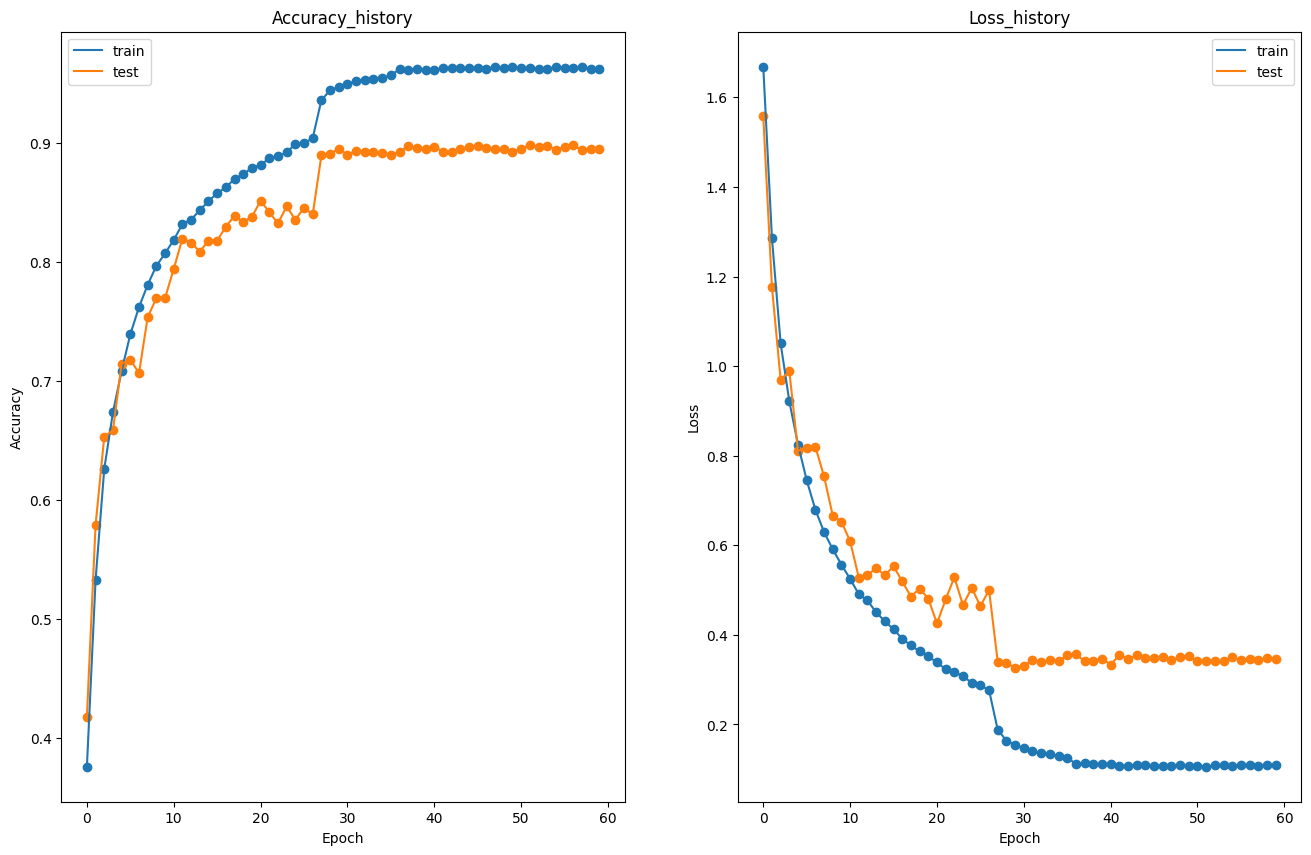

In [43]:
my_model = whole_train_valid_cycle(model, 60)